In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary
from pathlib import Path

from modules import data_setup
from modules import engine
from modules import utils
from helper_functions import plot_loss_curves

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
image_path = Path("scenes/")

train_dir = image_path / "seg_train"
test_dir = image_path / "seg_test"

In [4]:
# getting the pretrained_model

pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

pretrained_transforms = pretrained_vit_weights.transforms()
pretrained_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

In [5]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, 
                                                                               batch_size=16, 
                                                                               transform=pretrained_transforms)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1d28989df70>,
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

In [7]:
for params in pretrained_vit.parameters():
    params.requires_grad=False
    
pretrained_vit.heads = nn.Sequential(nn.LayerNorm(normalized_shape=768),
                                     nn.Linear(in_features=768, out_features=len(class_names)))

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 6]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [8]:
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=3e-3)

# results = engine.train(model=pretrained_vit, 
#                        train_dataloader=train_dataloader,
#                        test_dataloader=test_dataloader, 
#                        epochs=5, 
#                        loss_fn=loss_fn, 
#                        optimizer=optimizer,
#                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2745 | train_acc: 0.9072 | test_loss: 0.2516 | test_acc: 0.9176
Epoch: 2 | train_loss: 0.2015 | train_acc: 0.9300 | test_loss: 0.3063 | test_acc: 0.8979
Epoch: 3 | train_loss: 0.1883 | train_acc: 0.9335 | test_loss: 0.3394 | test_acc: 0.8920
Epoch: 4 | train_loss: 0.1716 | train_acc: 0.9397 | test_loss: 0.2208 | test_acc: 0.9309
Epoch: 5 | train_loss: 0.1593 | train_acc: 0.9423 | test_loss: 0.2416 | test_acc: 0.9282


In [ ]:
# # saving the model
# utils.save_model(model=pretrained_vit, 
#                  target_dir="models", 
#                  model_name="pretrained_vit_feature_extractor_scene_recognition.pth")

# # Get the model size in bytes then convert to megabytes
# pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_scene_recognition.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
# print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

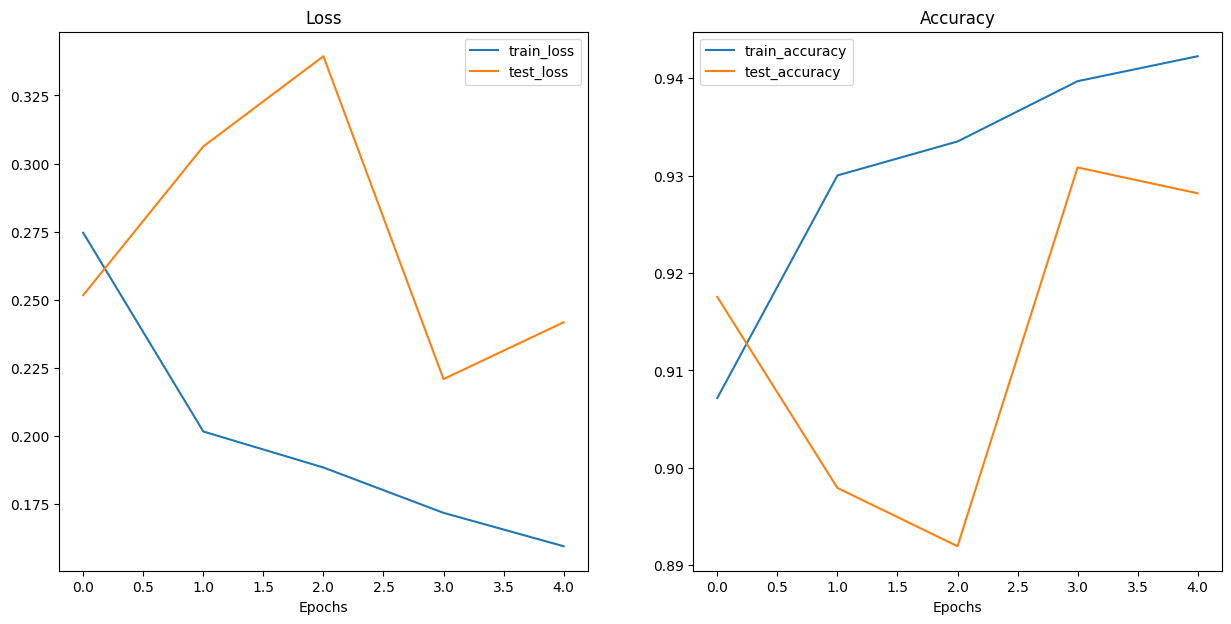

In [11]:
plot_loss_curves(results=results)

Based on the provided training results, we can analyze the performance of the model trained using the given hyperparameters. Here are some observations:

Loss: The training loss decreases gradually from epoch 1 to epoch 5, indicating that the model is learning and improving its performance on the training data.

Accuracy: The training accuracy steadily increases from epoch 1 to epoch 5, which suggests that the model is becoming more accurate in predicting the correct labels for the training samples.

Test Loss: The test loss fluctuates throughout the epochs, with a slight increase from epoch 1 to epoch 2 and then a decrease from epoch 2 to epoch 4. In the last epoch, the test loss increases slightly again. This behavior indicates that the model's performance on the unseen test data is not as consistent as on the training data.

Test Accuracy: The test accuracy remains relatively stable across the epochs, with values ranging from around 89% to 93%. This indicates that the model is generalizing well to the test data, achieving a similar level of accuracy as on the training data.

Overall, the model shows decent performance with high training accuracy and reasonable test accuracy. However, it seems that there might be some overfitting occurring, as the test loss fluctuates and the test accuracy does not improve significantly. To further improve the model's performance, you could try adjusting the hyperparameters, such as learning rate, optimizer, or increasing the number of epochs, and monitor the changes in training and test metrics. Another suitable idea might be to introduce augmentation in the training data.

Nevertheless, a 92.8% accuracy is still very good. Now we perform inference on the test set and visualize the results.

In [8]:
# Load the saved model state_dict
model_path = "models/pretrained_vit_feature_extractor_scene_recognition.pth"
pretrained_vit.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [9]:
# Get all test data paths
from tqdm import tqdm
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU 
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class
  
    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=pretrained_vit,
                                 transform=pretrained_transforms,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:45<00:00, 65.96it/s]


[{'image_path': WindowsPath('scenes/seg_test/buildings/20057.jpg'),
  'class_name': 'buildings',
  'pred_prob': 0.9990038275718689,
  'pred_class': 'buildings',
  'correct': True},
 {'image_path': WindowsPath('scenes/seg_test/buildings/20060.jpg'),
  'class_name': 'buildings',
  'pred_prob': 0.9992555975914001,
  'pred_class': 'buildings',
  'correct': True},
 {'image_path': WindowsPath('scenes/seg_test/buildings/20061.jpg'),
  'class_name': 'buildings',
  'pred_prob': 0.9997760653495789,
  'pred_class': 'buildings',
  'correct': True},
 {'image_path': WindowsPath('scenes/seg_test/buildings/20064.jpg'),
  'class_name': 'buildings',
  'pred_prob': 0.9999607801437378,
  'pred_class': 'buildings',
  'correct': True},
 {'image_path': WindowsPath('scenes/seg_test/buildings/20073.jpg'),
  'class_name': 'buildings',
  'pred_prob': 0.9999994039535522,
  'pred_class': 'buildings',
  'correct': True}]

In [10]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob 
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
1342,scenes\seg_test\glacier\23450.jpg,glacier,0.999997,sea,False
1346,scenes\seg_test\glacier\23497.jpg,glacier,0.999975,mountain,False
262,scenes\seg_test\buildings\22534.jpg,buildings,0.999931,street,False
1271,scenes\seg_test\glacier\22890.jpg,glacier,0.999867,mountain,False
88,scenes\seg_test\buildings\20846.jpg,buildings,0.999833,street,False


In [11]:
# How many samples from the test dataset did our model get correct?
test_pred_df.correct.value_counts()

correct
True     2785
False     215
Name: count, dtype: int64

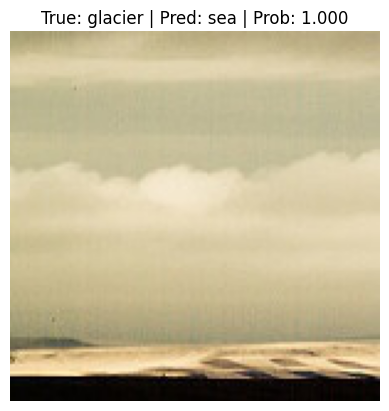

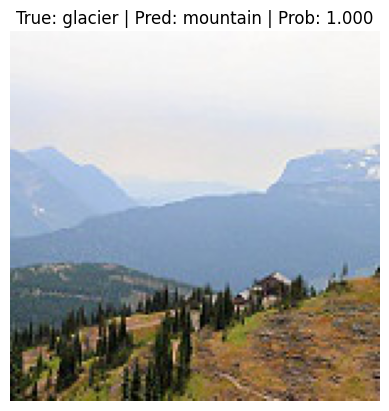

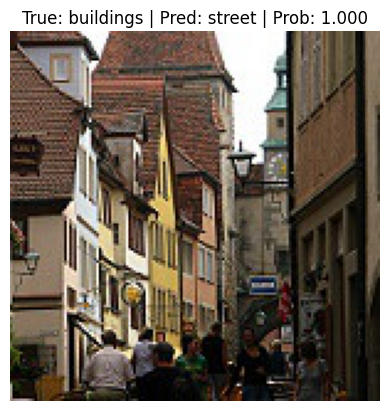

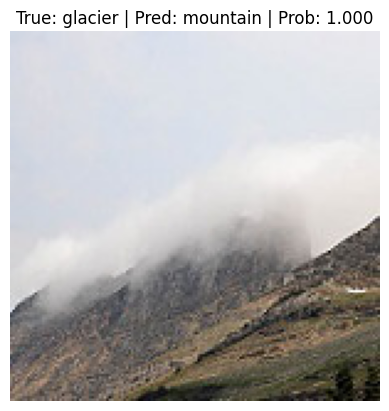

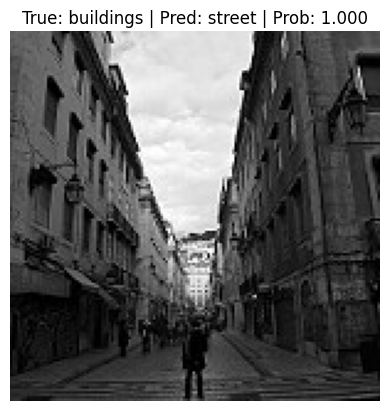

In [15]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False);

We can see that the images that the model predicted wrong are pretty ambiguous, and its understandable why a model would get them wrong. Some of them contain multiple classes at which point getting the correct one is just a guess between the two. So the performance of the model is pretty satsifactory.

Now we plot the confusion matrix

In [12]:
from torchvision import datasets
test_data = datasets.ImageFolder(test_dir, transform=pretrained_transforms)

In [13]:
# Get all test data paths
from tqdm import tqdm
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU 
      test_pred_list.append(pred_label.cpu().numpy())

  return test_pred_list

test_pred_list = pred_and_store(test_paths=test_data_paths,
                                 model=pretrained_vit,
                                 transform=pretrained_transforms,
                                 class_names=class_names,
                                 device=device)

test_pred_list[:5]

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:46<00:00, 64.66it/s]


[array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64)]

In [14]:
result_list = [arr[0].item() for arr in test_pred_list]
result_list[:5], test_data.targets[:5]

([0, 0, 0, 0, 0], [0, 0, 0, 0, 0])

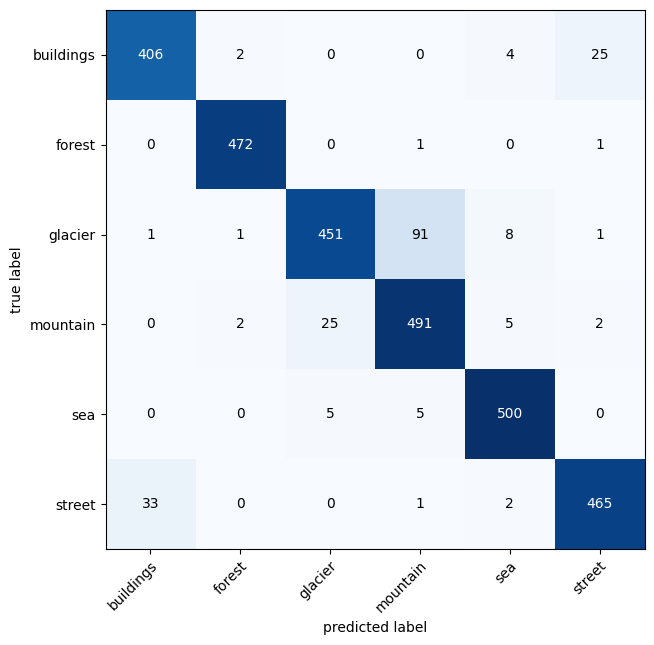

In [15]:
import torch
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Convert result_list and test_data.targets to PyTorch tensors
result_tensor = torch.tensor(result_list, dtype=torch.int64)
target_tensor = torch.tensor(test_data.targets, dtype=torch.int64)

# Setup confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=result_tensor, target=target_tensor)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

# Save the plot as an image
image_path = "confusion_matrix.png"
plt.savefig(image_path)